In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ast import literal_eval
from sklearn.metrics import auc
import numpy as np

In [2]:
controller_output = Path('output')

In [3]:
low_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
high_df = pd.read_csv(controller_output / '100_runs_highest_utility.csv')
random_df = pd.read_csv(controller_output / '100_runs_random_utility.csv')

In [4]:
for df in [low_df, high_df, random_df]:
    df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'] = df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'].apply(literal_eval)

## Rule Picking Strategies (for choosing action per issue)

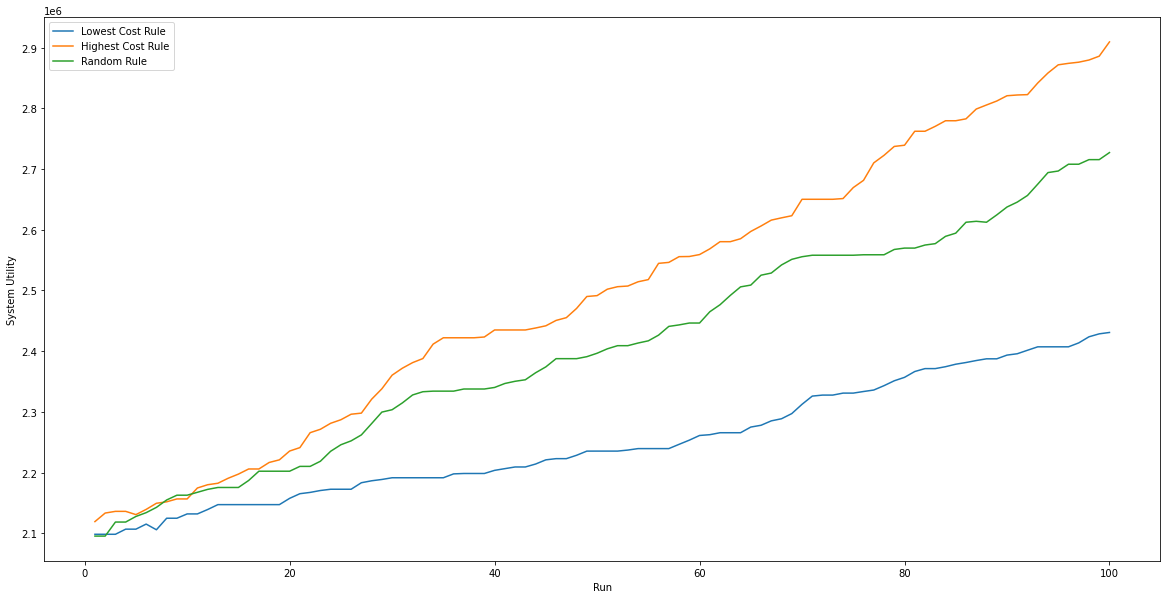

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='run', y='system_utility', data=low_df, ax=ax, ci=None, label='Lowest Cost Rule')
sns.lineplot(x='run', y='system_utility', data=high_df, ax=ax, ci=None, label='Highest Cost Rule')
sns.lineplot(x='run', y='system_utility', data=random_df, ax=ax, ci=None, label='Random Rule')
ax.set(xlabel='Run', ylabel='System Utility');

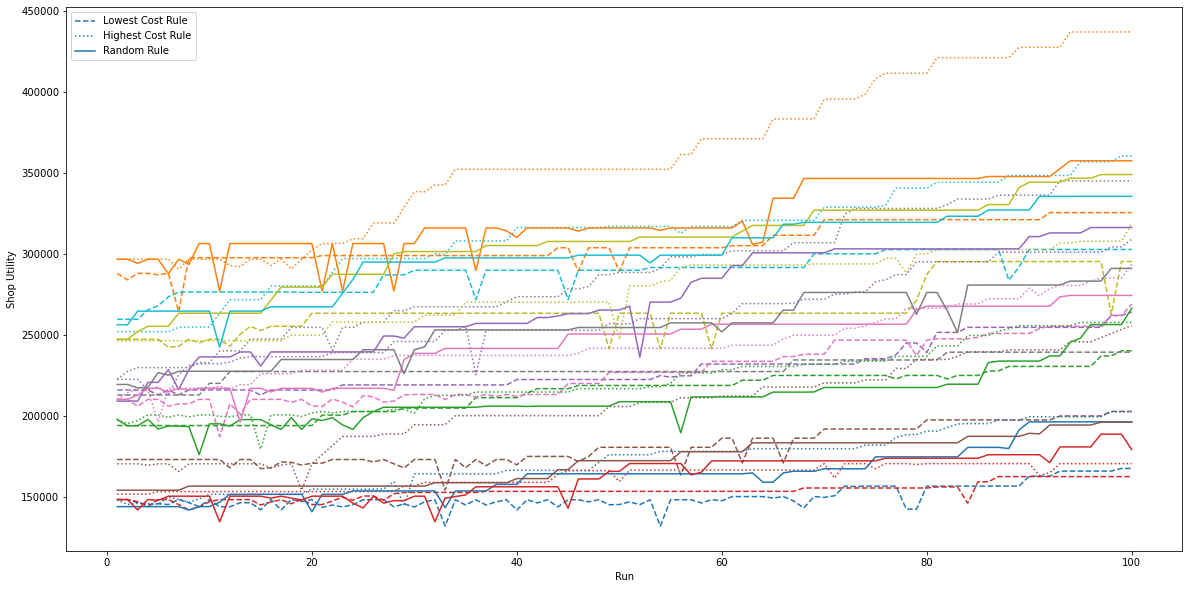

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
lowest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_df, ci=None, linestyle='dashed', ax=ax, label='Lowest Cost Rule', legend=False)
highest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=high_df, ci=None, linestyle='dotted', ax=ax, label='Highest Cost Rule', legend=False)
random = sns.lineplot(x='run', y='shop_utility', hue='shop', data=random_df, ci=None, ax=ax, label='Random Rule', legend=False)
ax.set(xlabel='Run', ylabel='Shop Utility');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::10], ['Lowest Cost Rule', 'Highest Cost Rule', 'Random Rule']);

## Issue Ranking Strategies

In [7]:
low_u_df = pd.read_csv(controller_output / '100_runs_lowest_utility.csv')
low_c_df = pd.read_csv(controller_output / '100_runs_lowest_cost.csv')
low_r_df = pd.read_csv(controller_output / '100_runs_lowest_random.csv')

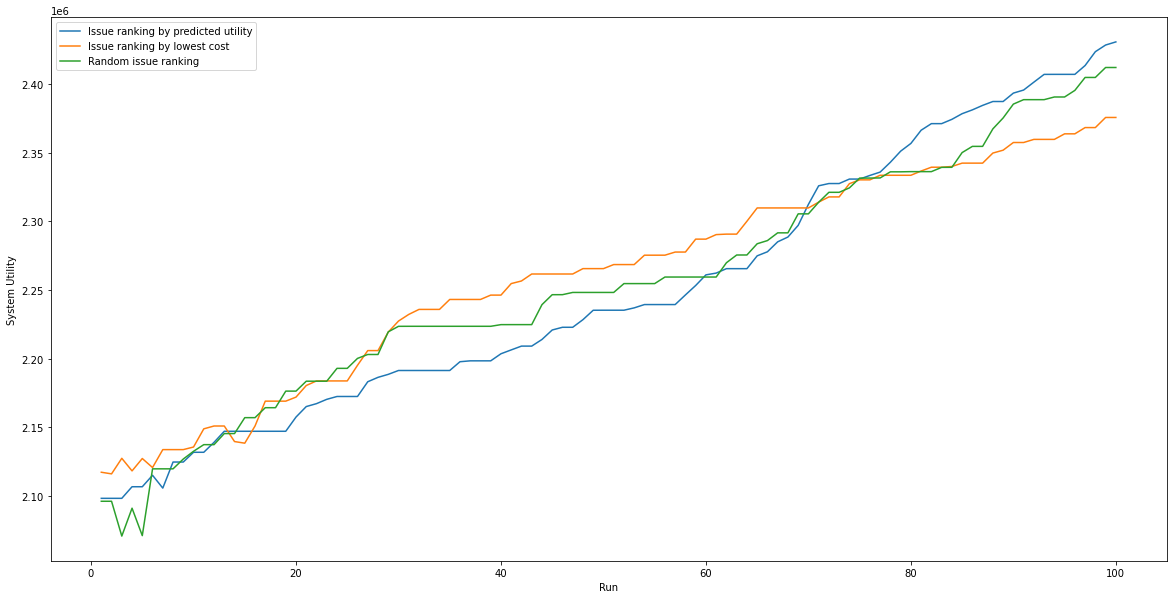

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x='run', y='system_utility', data=low_u_df, ax=ax, ci=None, label='Issue ranking by predicted utility')
sns.lineplot(x='run', y='system_utility', data=low_c_df, ax=ax, ci=None, label='Issue ranking by lowest cost')
sns.lineplot(x='run', y='system_utility', data=low_r_df, ax=ax, ci=None, label='Random issue ranking')
ax.set(xlabel='Run', ylabel='System Utility');

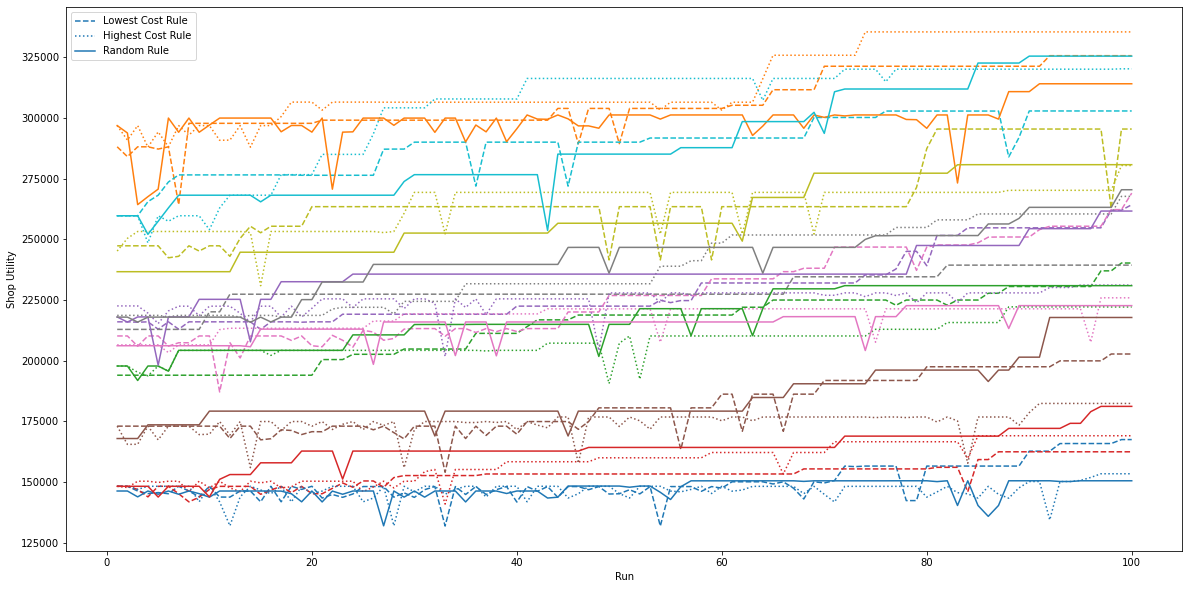

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
lowest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_u_df, ci=None, linestyle='dashed', ax=ax, label='Lowest Cost Rule', legend=False)
highest = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_c_df, ci=None, linestyle='dotted', ax=ax, label='Highest Cost Rule', legend=False)
random = sns.lineplot(x='run', y='shop_utility', hue='shop', data=low_r_df, ci=None, ax=ax, label='Random Rule', legend=False)
ax.set(xlabel='Run', ylabel='Shop Utility');
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::10], ['Lowest Cost Rule', 'Highest Cost Rule', 'Random Rule']);

In [42]:
for df in [low_u_df, low_c_df, low_r_df]:
    df['combined_index'] = 'after fixing ' + df['failure_name'].astype(str) + ' (' + df['shop'].astype(str) + ')'
    df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'] = df.loc[~df['predicted_optimal_utility'].isna(), 'rule_costs'].apply(literal_eval)

In [52]:
def replicate_issue_ranking(df, run, strategy='utility'):
    example = df.query('run == @run').copy()
    example_fixes = example.loc[~example['predicted_optimal_utility'].isna()].copy()
    example_fixes['min_cost'] = example_fixes['rule_costs'].apply(min)
    if strategy == 'utility':
        example_fixes = example_fixes.sort_values(['predicted_optimal_utility'], ascending=False)
    elif strategy == 'cost':
        example_fixes = example_fixes.sort_values(['min_cost'], ascending=True)
    elif strategy == 'random':
        example_fixes = example_fixes.sample(frac=1, random_state=42)
    else:
        raise NotImplementedError('Strategy {strategy} is not implemented')
    example_fixes['estimated_system_utility'] = example_fixes['system_utility'] + example_fixes['predicted_optimal_utility'].fillna(0).cumsum()
    if len(example_fixes) > 1:
        example_fixes['auc'] = auc(x=np.arange(len(example_fixes)), y=example_fixes['estimated_system_utility'].values)
    else:
        example_fixes['auc'] = np.nan
    return example_fixes

In [69]:
def plot_strategies_per_run(df, run):
    fig, ax = plt.subplots(figsize=(10,5))
    plotting_map = {
        'Random Ranking': 'random',
        'Cost Ranking': 'cost',
        'Utility Ranking': 'utility',
    }
    for label, strategy in plotting_map.items():
        replicate_issue_ranking(df, run, strategy).plot(
            x='combined_index',
            y='estimated_system_utility',
            drawstyle='steps-post',
            rot=90,
            ax=ax,
            label=label
        )

    ax.set(xlabel='Addressed Issues', ylabel='System Utility', title=f'Run {run}')
    return fig

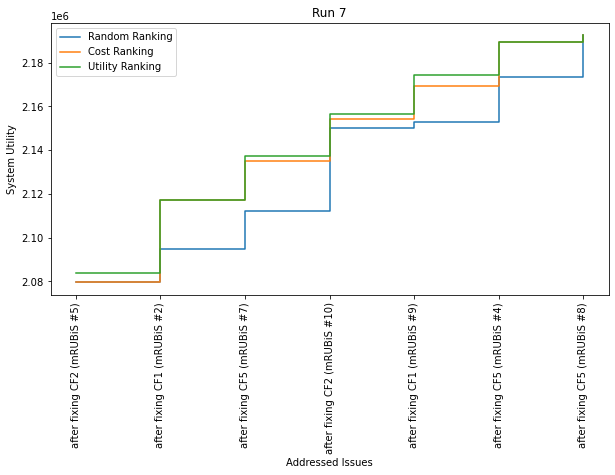

In [70]:
plot_strategies_per_run(low_u_df, 7);